In [254]:
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import sqlite3
import rubin_sim
import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import SkyAreaGenerator
from rubin_sim.data import get_baseline
rubin_sim.__version__

'1.3.2'

In [255]:
from os import path

opsim_fname = rubin_sim.data.get_baseline()
run_name = path.splitext(path.basename(opsim_fname))[0]
print(f"Using {run_name}, to be read from {opsim_fname}")
# opsim_fname is being pulled from a rubin_sim command - Heather is going to update this.

Using baseline_v2.1_10yrs, to be read from /global/cfs/cdirs/lsst/groups/CO/rubin_sim/sim_baseline/baseline_v2.1_10yrs.db


In [256]:
# Routines to do stuff with maps - so we can make a survey mask.
def load_maf_map(fname):
    
    fin = maf.MetricBundle(
        metric=maf.ExgalM5(),
        slicer=maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=np.where(map_labels == "lowdust")[0]),
        constraint='note not like "DD%" and note not like "twilight_neo"'
    )
    fin._setup_metric_values()
    #counts/map values
    opmap=fin.metric_values
    mafmap=np.copy(opmap.data)
    mafmap[opmap.mask]=0
    mafmap[mafmap>0]=1
    
    return mafmap

def maf_maps_to_fits(fname_in):
    usemap = load_maf_map(fname_in)
    # save this into fits file:
    fname = './map_for_paul.fits'
    hp.write_map(fname, usemap, overwrite=True)
    print("Written: %s"%fname)
    

In [257]:
# Write a map for Paul based on v3.3
fname_for_paul = "/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db"
#maf_maps_to_fits(fname_for_paul)

In [258]:
# Make sure it looks OK.
#test_map = hp.read_map('map_for_paul.fits')
#print(np.min(test_map), np.max(test_map))
#hp.mollview(test_map)

In [259]:
# Plot wish-list:
# After cutting to extragalactic WFD area (approx done), we want the following:
#   - Distribution of i-band coadd M5 values at each data release from year 1 - year 10 (DR2-DR11)... so far just year 10
#   - Later we want all bands, not just i
# We want to be able to compare across different axes:
#   - For a given strategy, compare distributions at various years -> Renee working on this.
#   - For a given year, compare distributions across strategies -> integrate Renee's development from before
#   - for a given year and strategy, compare distributions across bands.
# Then take the RMS values and use Arun's stuff to turn them into RMS <z>.
# Figure out how to connect with the Delta delta group.
# Incorporated combined depth from Matt once he has it

## Let's start with a simple metric bundle of only the ExgalM5 metric
Remember that the list of metrics is here: https://rubin-sim.lsst.io/rs_maf/metric_list.html

In [269]:
# Here we define a function for some of the metric plots we want to show.
# TODO: allow customization of metric resolution, results for intermediate years.
# Can use plot_funcs kwarg in metric_plots to change what is plotted.
# Check varying `nside` once we can load dust maps
nside=64
surveyAreas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = surveyAreas.return_maps()
def metric_plots(use_run_name, use_opsim_fname, use_metric=maf.ExgalM5(), use_color_min=None, use_color_max=None,
                year=10):
    # use_run_name says which OpSim DB we want to use, e.g. `baseline_v2.1_10yrs` - will also be used for labels
    # use_opsim_fname says where it lives, e.g. `/global/cfs/cdirs/lsst/groups/CO/rubin_sim/sim_baseline/baseline_v2.1_10yrs.db`
    days = year*365.3
    constraint_str='filter="i" and note not like "DD%" and night <= XX and note not like "twilight_neo" '
    constraint_str = constraint_str.replace('XX','%d'%days)
    if use_color_min is not None and use_color_max is not None:
        plot_dict={"color_min": use_color_min, "color_max": use_color_max, "x_min": use_color_min, "x_max": use_color_max}
    else:
        plot_dict=None
    depth_map_bundle = maf.MetricBundle(
        metric=use_metric,
        # previous line was originally using maf.Coaddm5Metric()
        slicer=maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=np.where(map_labels == "lowdust")[0]),
        #slicer=maf.HealpixSlicer(nside=nside, use_cache=False),
        # Above has changed to avoid high dust regions
        constraint=constraint_str,
        # Reject certain types of observations
        run_name=use_run_name,
        summary_metrics=[maf.MedianMetric(), maf.MeanMetric(), maf.RmsMetric()],
        plot_dict=plot_dict
    )
    print('Bundle diagnostics',depth_map_bundle.run_name, depth_map_bundle.metric.name, 
        depth_map_bundle.info_label, depth_map_bundle.slicer.slicer_name)
    
    bd = maf.metricBundles.make_bundles_dict_from_list([depth_map_bundle])
    bgroup = maf.MetricBundleGroup(
        bd, use_opsim_fname
    )
    bgroup.run_all()
    
    return bgroup, bd

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Bundle diagnostics roll_mid2_const_season6v3.3_10yrs ExgalM5 i and note not like DD% and night < 730 and note not like twilight_neo HealpixSubsetSlicer


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


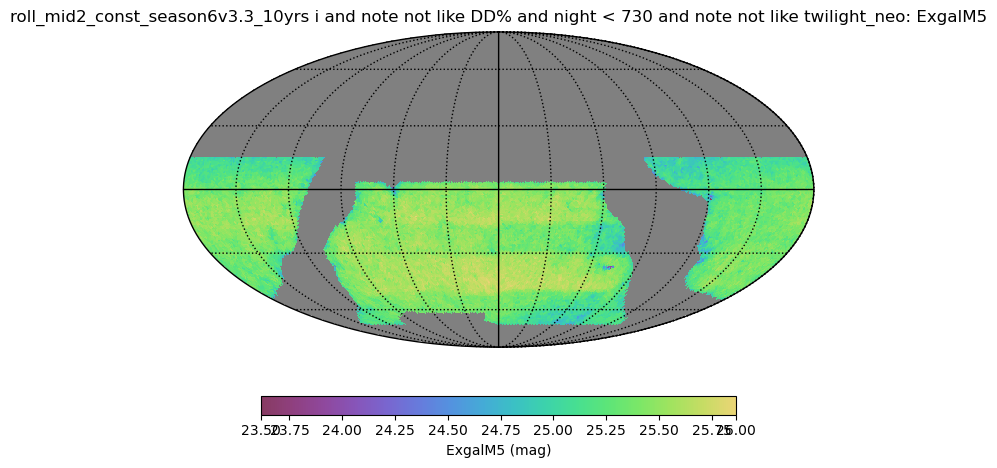

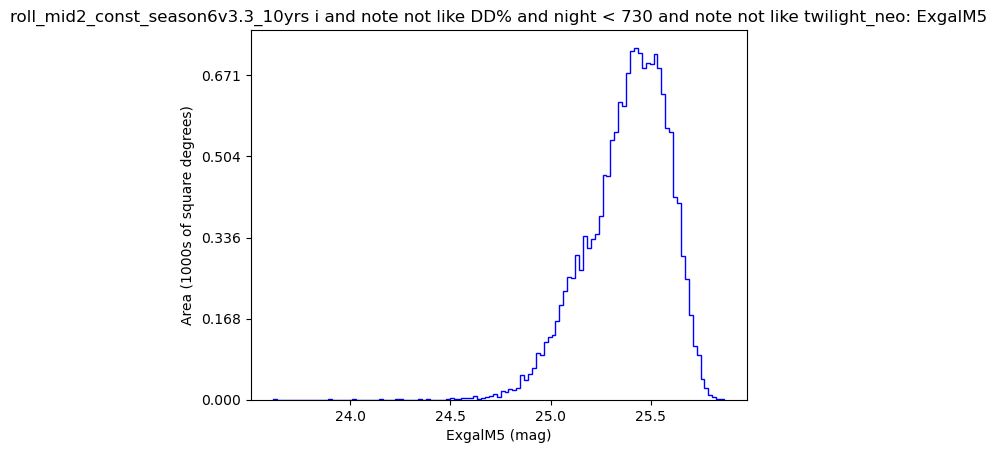

In [272]:
# Apply the above routine to our baseline sim, and show the plots
bgroup, bd = metric_plots(run_name, opsim_fname, year=2)
bgroup.plot_all(closefigs=False)

In [273]:
pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))

,Median,Mean,Rms
roll_mid2_const_season6v3_3_10yrs_ExgalM5_i_and_note_not_like_DD_and_night_lt_730_and_note_not_like_twilight_neo_HEAL,25.409858,25.381524,0.200743


### What if we want to change the opsim we are using?
We define a new opsim file name and then regenerate the metric on this new opsim

No roll v3.3 will be read from /pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Bundle diagnostics No roll v3.3 ExgalM5 i and note not like DD% and note not like twilight_neo HealpixSubsetSlicer


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


,Median,Mean,Rms
No_roll_v3_3_ExgalM5_i_and_note_not_like_DD_and_note_not_like_twilight_neo_HEAL,26.4203,26.391543,0.157775


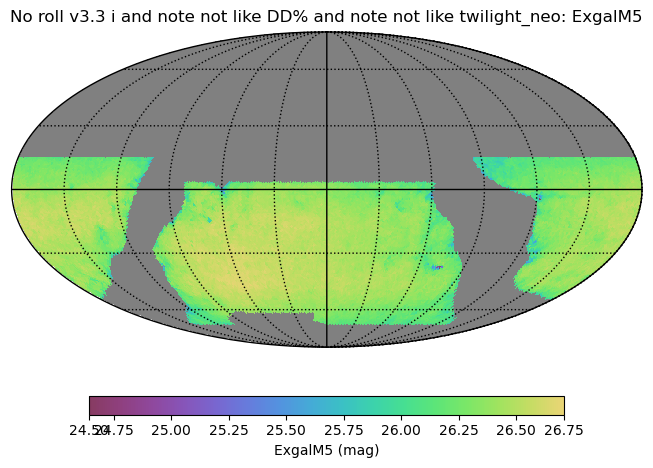

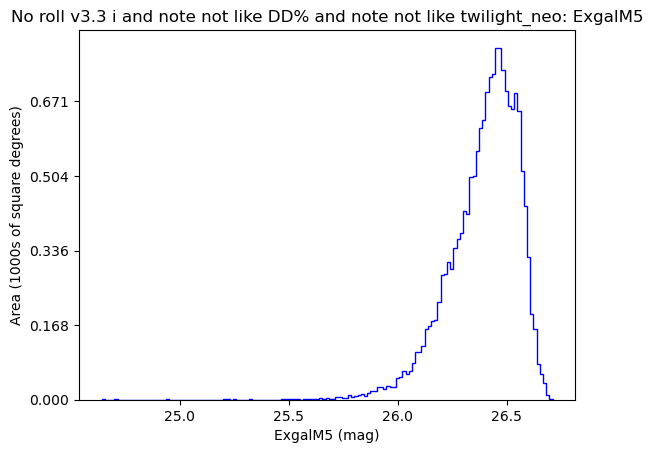

In [263]:
# This lives in Renee's space and she has hacked permissions so the rest of us can read it.  
# But Heather is going to make these accessible in a more sound way.  We'll make and show the same plots for this new strategy.
new_opsim_fname = '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db'
new_run_name = 'No roll v3.3'
print(f"{new_run_name} will be read from {new_opsim_fname}")
newbgroup, newbd = metric_plots(new_run_name, new_opsim_fname)
newbgroup.plot_all(closefigs=False)
pd.DataFrame([newbd[k].summary_values for k in newbd], index=list(newbd.keys()))

In [264]:
# All together now, just summary stats
sim_list = ['/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season2v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season4v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season6v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season2v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season4v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season6v3.3_10yrs.db',]
name_list = [path.splitext(path.basename(sim))[0] for sim in sim_list]
for sim in sim_list:
    run_name = path.splitext(path.basename(sim))[0]
    print(run_name)
    tmpbgroup, tmpbd = metric_plots(run_name, sim)
    print(tmpbd[list(tmpbd.keys())[0]].summary_values)
    #pd.DataFrame([tmpbd[k].summary_values for k in tmpbd], index=list(tmpbd.keys()))    


baseline_v3.3_10yrs
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Bundle diagnostics baseline_v3.3_10yrs ExgalM5 i and note not like DD% and note not like twilight_neo HealpixSubsetSlicer


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


{'Median': 26.398118929020136, 'Mean': 26.36654701955083, 'Rms': 0.15996924818962502}
noroll_v3.3_10yrs
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Bundle diagnostics noroll_v3.3_10yrs ExgalM5 i and note not like DD% and note not like twilight_neo HealpixSubsetSlicer
{'Median': 26.420299950017423, 'Mean': 26.391542542185686, 'Rms': 0.15777483355196803}
roll_mid1_const_season2v3.3_10yrs
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Bundle diagnostics roll_mid1_const_season2v3.3_10yrs ExgalM5 i and note not like DD% and note not like twilight_neo HealpixSubsetSlicer
{'Median': 26.392930143378766, 'Mean': 26.367526445924824, 'Rms': 0.15890426183190137}
roll_mid1_const_season4v3.3_10yrs
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Bundle diagnostics roll_mid1_const_season4v3.3_10yrs ExgalM5 i and note not like DD% and note not like twilight_neo HealpixSubsetSlicer
{'Median': 26.3959376593151, 'Mean': 

In [267]:
# Define combined plotting routine - base it on Renee's
def combined_metric_plots(use_run_name_vec, use_opsim_fname_vec, 
                          use_metric=maf.ExgalM5(), year=10, use_color_min=None, use_color_max=None):
    # use_run_name_vec says which OpSim DBs we want to use - will also be used for labels
    # use_opsim_fname_vec says where they live, e.g. one item might be `/global/cfs/cdirs/lsst/groups/CO/rubin_sim/sim_baseline/baseline_v2.1_10yrs.db`
    if use_color_min is not None and use_color_max is not None:
        plot_dict={"color_min": use_color_min, "color_max": use_color_max, "x_min": use_color_min, "x_max": use_color_max}
    else:
        plot_dict=None
    days = year*365.3
    constraint_str='filter="i" and note not like "DD%" and night <= XX and note not like "twilight_neo" '
    constraint_str = constraint_str.replace('XX','%d'%days)
    print(constraint_str)
    
    bg_list = []
    bd_list = []
    overall_plot_dict = {}
    color_list = ["k", "r", "b", "c", "g", "o", "m", "y"] # hopefully long enough to handle everything
    for i in range(len(use_run_name_vec)):
        use_run_name = use_run_name_vec[i]
        use_opsim_fname = use_opsim_fname_vec[i]
        print(use_run_name, use_opsim_fname)
        depth_map_bundle = maf.MetricBundle(
            metric=use_metric,
            slicer=maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=np.where(map_labels == "lowdust")[0]),
            constraint=constraint_str,
            run_name=use_run_name,
            summary_metrics=[maf.MedianMetric(), maf.MeanMetric(), maf.RmsMetric()],
            plot_dict=plot_dict
        )
        #print('Bundle diagnostics',depth_map_bundle.run_name, depth_map_bundle.metric.name, 
        #      depth_map_bundle.info_label, depth_map_bundle.slicer.slicer_name, depth_map_bundle.file_root)
        
        bd = maf.metricBundles.make_bundles_dict_from_list([depth_map_bundle])
        print(bd[list(bd.keys())[0]].summary_values)
        #bgroup = maf.MetricBundleGroup(
        #    bd, use_run_name, out_dir="./"
        #)
        #bgroup.run_all()
        
        #bg_list.append(bgroup)
        #bd_list.append(bd)
        #overall_plot_dict[use_run_name] = color_list[i]
    
    #ph = maf.PlotHandler()
    #ph.set_metric_bundles(bg_list)
    #ph.plot(plot_dicts=overall_plot_dict)
    #for i in range(len(bd_list)): print(use_opsim_fname_vec[i], year, bd_list[i][list(bd_list[i].keys())[0]].summary_values)
    #for tmpbd in bd_list: print(tmpbd[list(tmpbd.keys())[0]].summary_values)
 

In [268]:
smaller_sim_list = [sim_list[0], sim_list[1]]
smaller_fname_list = [path.splitext(path.basename(sim_list[0]))[0], path.splitext(path.basename(sim_list[1]))[0]]
#print(sim_list)
#print(name_list)
for year in range(1,3):
    #combined_metric_plots(sim_list, name_list, year=year)
    combined_metric_plots(smaller_sim_list, smaller_fname_list, year=year)

filter="i" and note not like "DD%" and night <= 365 and note not like "twilight_neo" 
/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db baseline_v3.3_10yrs
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
None
/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db noroll_v3.3_10yrs
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
None
filter="i" and note not like "DD%" and night <= 730 and note not like "twilight_neo" 
/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db baseline_v3.3_10yrs
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
None
/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db noroll_v3.3_10yrs
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
None
